In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yusufsolomon","key":"e378448c6a8d7681946eb3a7f4970494"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir trafficsign_dataset


In [ ]:
%cd trafficsign_dataset

/content/trafficsign_dataset


In [ ]:
!kaggle datasets list -s german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34         118643       1152  0.8235294        
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                        118MB  2023-07-11 04:21:24           1342         32  1.0              
safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb        GTSDB - German Traffic Sign Detection Benchmark      2GB  2020-11-20 11:21:11           2604         15  0.5625           
valentynsichkar/traffic-signs-preprocessed        

In [ ]:
!kaggle datasets download harbhajansingh21/german-traffic-sign-dataset

Dataset URL: https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset
License(s): other
 90% 106M/118M [00:01<00:00, 154MB/s] 
100% 118M/118M [00:01<00:00, 107MB/s]


In [ ]:
%cd ..

/content


In [ ]:
!unzip trafficsign_dataset/german-traffic-sign-dataset

Archive:  trafficsign_dataset/german-traffic-sign-dataset.zip
  inflating: signname.csv            
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import pickle
import csv
import random
import pandas as pd
from matplotlib.image import imread
from sklearn.model_selection import train_test_split

In [ ]:
#function for reading the pickle data
def load_p_data(fle):
  #reading the file
  with open(fle, 'rb') as f:
    #reading the contents of the pickle file as a dictionary
    d= pickle.load(f, encoding='latin1')
    feats = d['features'] #4D numpy array containing raw pixel data of the traffic sign images
    labels = d['labels'] #1D numpy array containing the label id of the traffic sign images (labels are encoded)
    sizes = d['sizes'] #2D numpy array containing the sizes of the images i.e. (width,height)
    coords = d['coords'] #2D array contains the coordinates for a bounding frame arround the image
  return feats, labels, sizes, coords


train_features, train_labels, train_sizes, train_coords = load_p_data("/content/train.p")
test_features, test_labels, test_sizes, test_coords = load_p_data("/content/test.p")
valid_features, valid_labels, valid_sizes, valid_coords = load_p_data("/content/valid.p")



In [ ]:
#defining a function for getting all labels
def label_text(fle):
  #list for saving label text
  label_list = []
  #reading csv file (signname.csv)
  with open(fle, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      label_list.append(row[1]) #taking the second column for each row (the label name)
    del label_list[0] #delete first element of the list because it is not part of the labels
  return label_list

labels = label_text("/content/signname.csv")

Class Name: Speed limit (20km/h)


<Figure size 1400x1400 with 0 Axes>

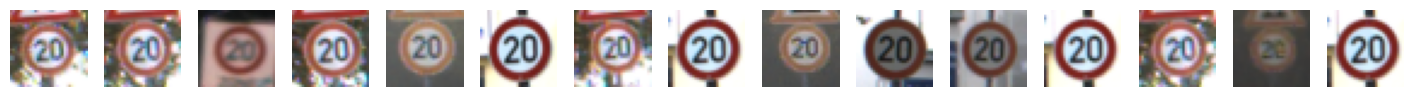

Class Name: Speed limit (30km/h)


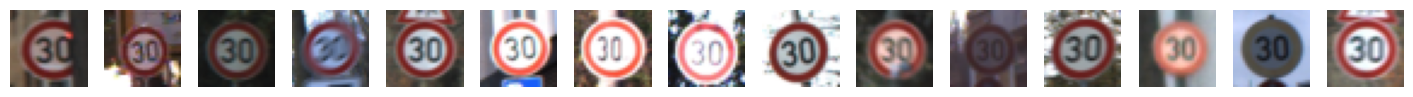

Class Name: Speed limit (50km/h)


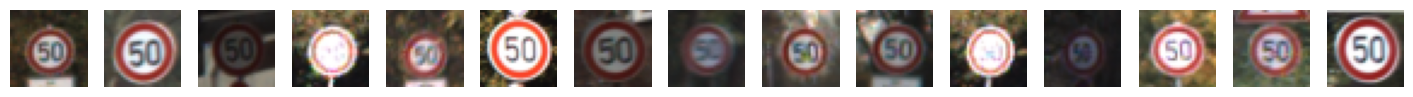

Class Name: Speed limit (60km/h)


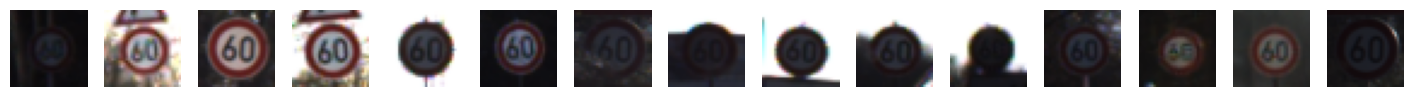

Class Name: Speed limit (70km/h)


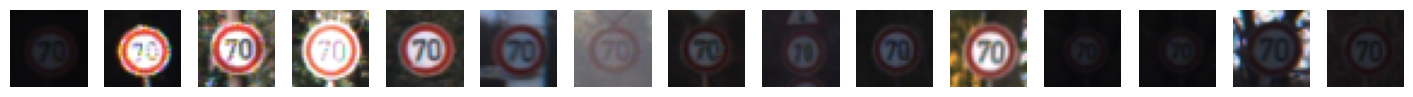

Class Name: Speed limit (80km/h)


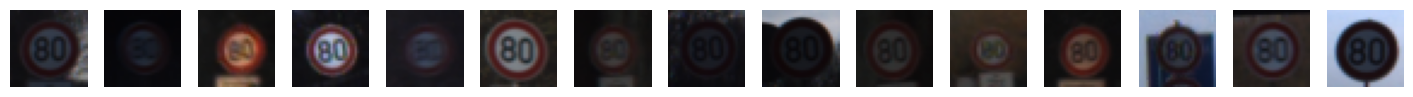

In [ ]:
#plotting images for each class
classes, class_indices, class_counts  = np.unique(train_labels, return_index=True, return_counts=True)

def plot_images(images, labels):
    plt.figure(figsize = (14, 14))
    p = 0
    for c, c_i, c_count in zip(classes, class_indices, class_counts):
        print(f"Class Name: {labels[c]}")
        fig = plt.figure(figsize = (18, 1))
        p+=1
        for i in range(15):
            plt.subplot(1,15, i+1)
            plt.imshow(images[np.random.randint(c_i, c_i + c_count, 15)[i],:,:,:])
            plt.axis("off")
        plt.show()
        print (images[i].size)
        if p == 6:
          break
plot_images(train_features, labels)



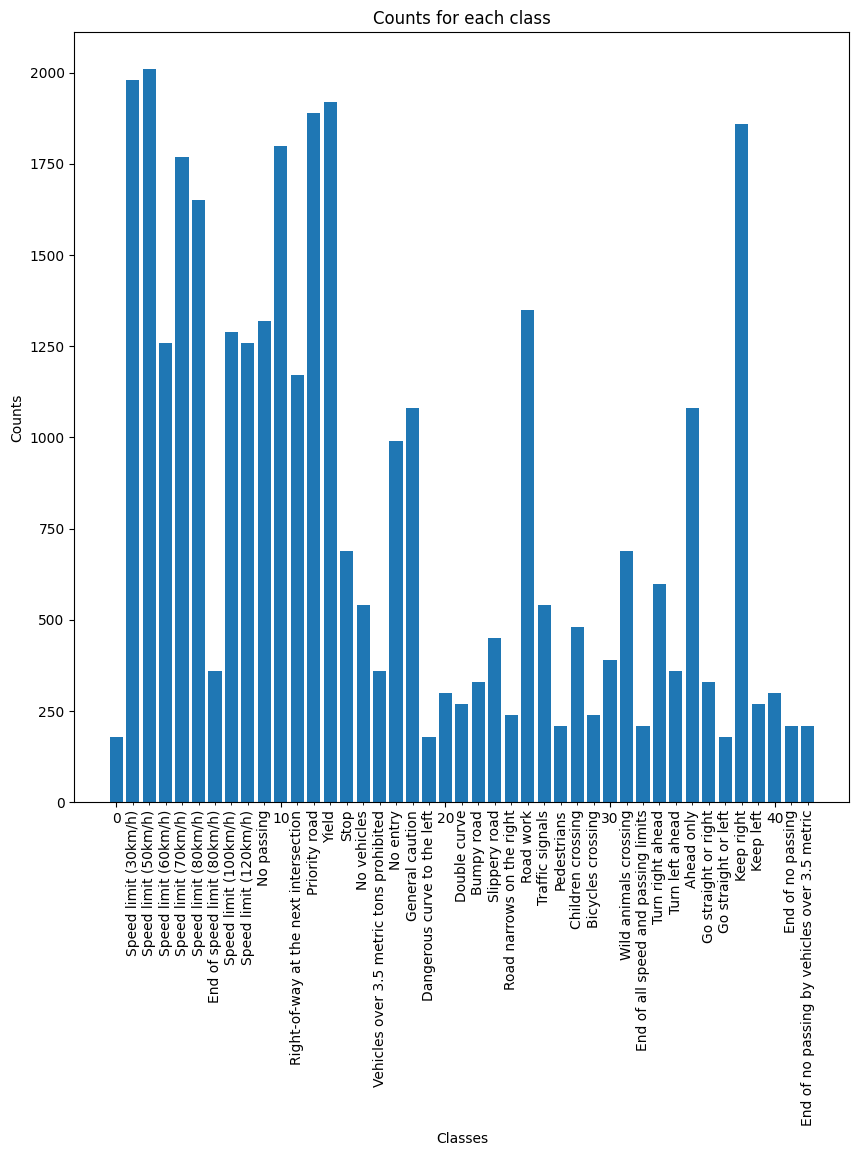

In [ ]:
#plotting class counts

plt.figure(figsize= (10,10))
plt.bar(classes, class_counts)

plt.title('Counts for each class')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(classes, labels , minor = True, rotation = 90)

plt.show()

In [ ]:
#create a function that normalizes the images
image_datagenerator = ImageDataGenerator(rescale = 1/255)

#OneHotEncode labels

train_labels = to_categorical(train_labels, num_classes = 43)
test_labels = to_categorical(test_labels, num_classes = 43)
valid_labels = to_categorical(valid_labels, num_classes = 43)

#generating new images and normalizing them
train_data = image_datagenerator.flow(train_features, train_labels, batch_size = 43)
test_data = image_datagenerator.flow(test_features, test_labels, batch_size = 43)
valid_data = image_datagenerator.flow(valid_features, valid_labels, batch_size = 43)



In [ ]:
#Building the CNN model
model = Sequential()

model.add(Conv2D(filters = 43, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = [32 , 32, 3]))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

#output layer
model.add(Dense(43, activation = 'softmax')) #number of neurons should be the number of classes and this is the last class

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 43)          │           3,268 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 43)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 43)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 574,575 (2.19 MB)

 Trainable params: 574,575 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 5, verbose = 1, restore_best_weights = True)


In [ ]:
model_history = model.fit(x = train_data, epochs = 20, validation_data = valid_data, callbacks = [early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


810/810 ━━━━━━━━━━━━━━━━━━━━ 114s 138ms/step - accuracy: 0.3412 - loss: 2.3464 - val_accuracy: 0.7420 - val_loss: 0.7624
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - accuracy: 0.8407 - loss: 0.4907 - val_accuracy: 0.8426 - val_loss: 0.5075
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 105s 129ms/step - accuracy: 0.9122 - loss: 0.2777 - val_accuracy: 0.8907 - val_loss: 0.3604
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 142s 129ms/step - accuracy: 0.9374 - loss: 0.1929 - val_accuracy: 0.9129 - val_loss: 0.3285
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 108s 133ms/step - accuracy: 0.9497 - loss: 0.1604 - val_accuracy: 0.9052 - val_loss: 0.3764
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 104s 129ms/step - accuracy: 0.9584 - loss: 0.1352 - val_accuracy: 0.9288 - val_loss: 0.2591
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 144s 132ms/step - accuracy: 0.9618 - loss: 0.1209 - val_accuracy: 0.9320 - val_loss: 0.2301
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.9661 - loss: 0.10

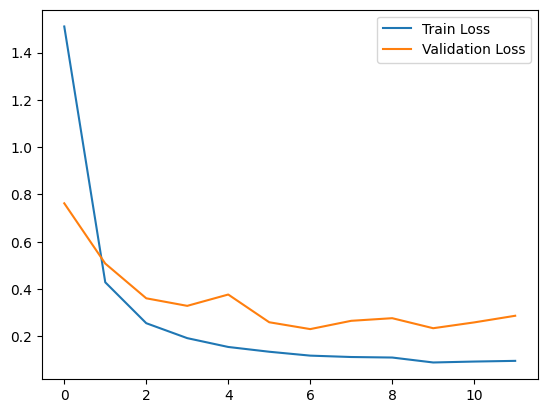

In [ ]:
plt.plot(model_history.history["loss"], label = "Train Loss")
plt.plot(model_history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

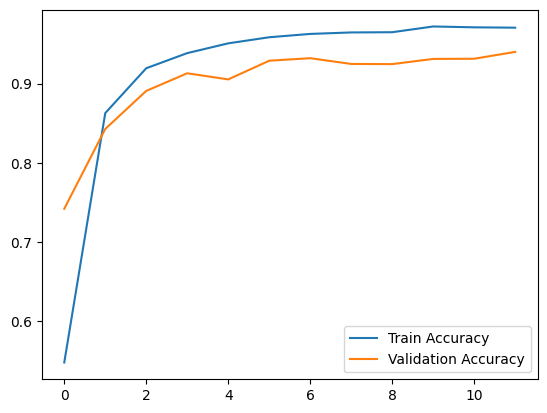

In [ ]:
plt.plot(model_history.history["accuracy"], label = "Train Accuracy")
plt.plot(model_history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

  3/294 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8747 - loss: 0.4549

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9184 - loss: 0.3041


[0.31756433844566345, 0.9193982481956482]

In [ ]:
#defining function to get the confusion matrix
def prediction_with_confusion_matrix(test_file, model):
    x_test, y_test, _, _ = load_p_data(test_file)
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow(x_test, y_test, batch_size=43, shuffle=True)
    y_pred = []
    y_true = []
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        batch_pred = model.predict(batch_x)
        batch_pred_classes = np.argmax(batch_pred, axis=1)

        y_pred.extend(batch_pred_classes)
        y_true.extend(batch_y)

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    unique_labels = np.unique(y_true)
    return confusion_matrix(y_true, y_pred, labels=unique_labels)

cmt = prediction_with_confusion_matrix("/content/test.p", model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

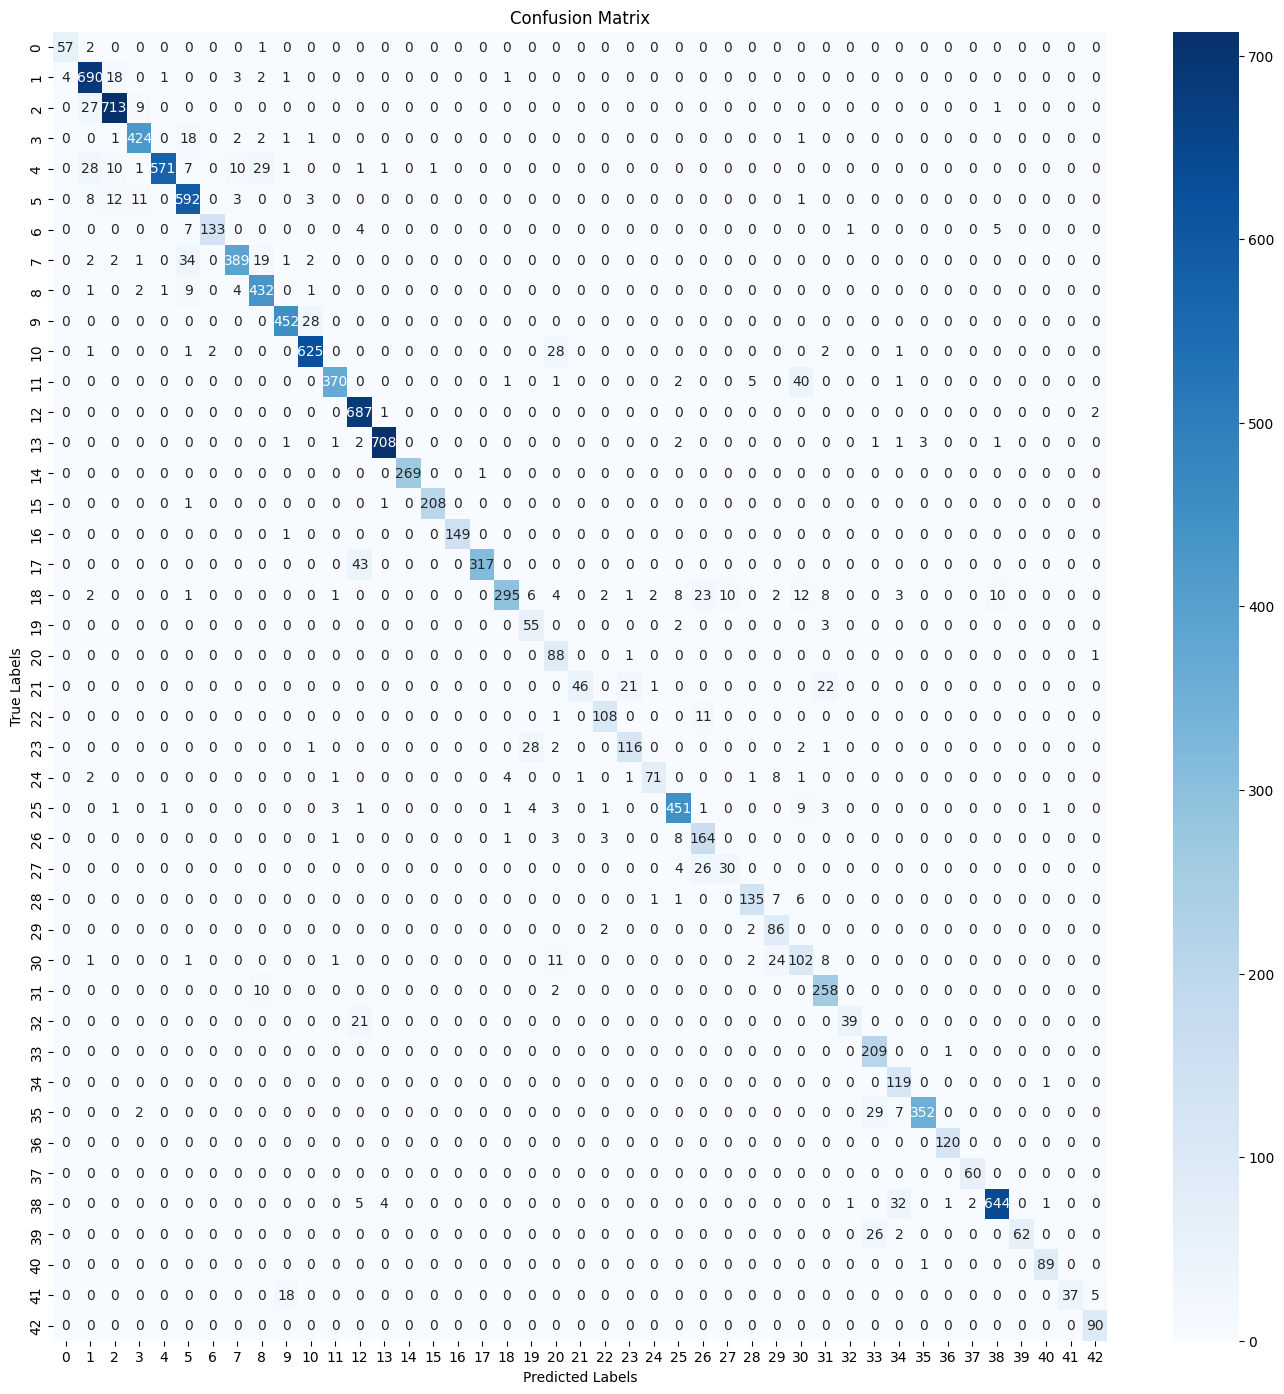

In [ ]:
plt.figure(figsize=(17, 17))
sns.heatmap(cmt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
labels

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing 

In [ ]:
#filename = 'labels.csv'
#with open(filename, 'w', newline='') as file:
 #   writer = csv.writer(file)

    # Write each row from the list
  #  writer.writerows(labels)

In [ ]:
#model.save('traffic_sign_model.h5')

In [ ]:
files.upload()




In [ ]:
sample = Image.open("path_to_your_image.jpg")
img_rescaled = sample.astype('float32') / 255
prediction = model.predict(np.expand_dims(img_rescaled, axis=0))
predicted_class = np.argmax(prediction, axis=1)
